# Vanilla **Actor-Critic**

My notes on Actor-Critic Algorithm. 

## Symbol Lookup Table


| Symbol             	| Definition                                                                                   	|
|--------------------	|----------------------------------------------------------------------------------------------	|
| $s \in S$          	| $s$ denotes a state.                                                                         	|
| $a \in A$          	| $a$ denotes an action.                                                                       	|
| $r \in R$          	| $r$ denotes a reward.                                                                        	|
| $ \pi(a \vert s) $ 	| Policy function, returns probability of choosing action $a$ in state $s$.                    	|
| $V(s)$             	| State-Value function, Measures how good a state is. (in terms of expected reward).           	|
| $V^\pi (s)$        	| State-Value function, When we are using policy $\pi$.                                        	|
| $Q^\pi$            	| Action-value function, Measures how good an action is.                                       	|
| $Q^\pi (s, a)$     	| Action-value function, How good is to take action $a$ in state $s$ when we use policy $\pi$. 	|
| $\gamma$           	| Discount factor.                                                                             	|
| $G_t$              	| Total return value.                                                                          	|
| $Q^\pi$            	| Action-value function.                                                                       	|
| $V^\pi$            	| State-value function.                                                                        	|


## Definition
In traditional policy gradient method, we have one neural network for our policy and after earch episode, we update its parameters $\theta$. The main idea behind **Actor-Critic** method is, why not using *Value-Function* for our policy updates? It's been said that Value-Function can be helpful by reducing the variance of policy gradient (or variance of gradient of policy)! 🤷

### Batch Mode

In batch mode you gather lots of data by interacting with the environment and sampling from policy $\pi$, and then updating your parameters using all information you gathered.

1. Sample a set of ${s_i, a_i}$ from policy $\pi_\theta(a \vert s)$.
1. Fit $\hat{V}_\theta^\pi(s)$ (neural network) to sampled rewad sums.
  1. Supervised regression with loss: $ \mathcal{L} (\theta) = \frac{1}{2} \sum_{t} \vert \vert \hat{V}_\theta^\pi(s_t) - [ r(s_{t}, a_{t} ) +  \hat{V}_\theta^\pi(s_{t+1}) ]  \vert \vert ^2 $.
1. Evaluate $ \hat{A}^\pi (s_t, a_t) = r(s_t, a_t) + \gamma \hat{V}_\theta^\pi(s'_t) - \hat{V}_\theta^\pi(s_t)$.
1. Calculate gradient $ \nabla_\theta J (\theta) \approx \sum_{i} \nabla_\theta log \pi_\theta (a_t \vert s_t) \hat{A}^\pi (s_i, a_i)$.
1. Update parameteres $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$.

### Online Mode

In online mode, you run your policy and after each interaction with the environment, you update your parameters. In practice we don't use this mode, because we are using neural networks and SGD. If you manage yo parallelize simulation, you can use this method.


1. Sample an action, reward and next state; $a \sim \pi_\theta(a \vert s)$, get $(s,a,s',r)$
1. Update $\hat{V}_\theta^\pi(s)$ using target $r+ \gamma \hat{V}_\theta^\pi(s')$
1. Evaluate $ \hat{A}^\pi (s, a) = r(s, a) + \gamma \hat{V}_\theta^\pi(s') - \hat{V}_\theta^\pi(s)$.
1. Calculate gradient $ \nabla_\theta J (\theta) \approx  \nabla_\theta log \pi_\theta (a \vert s) \hat{A}^\pi (s, a)$.
1. Update parameteres $\theta \leftarrow \theta + \alpha \nabla_\theta J(\theta)$.


### Another formulation

If you don't understand the above formulation, here is another one for you:

1. Initialize network parameters at random; $w, \theta$. Start from state $s$.
1. for $t=1 ... T$:
  1. Sample the following:
    1. Sample action; $a \sim \pi_\theta(a \vert s) $
    1. Sample reward; $r_t \sim R(s, a)$
    1. Sample next state; $s' \sim P(s' \vert s,a)$
    1. Sample next action; $a' \sim \pi_\theta (a' \vert s')$
  1. Update policy parameters $\theta$ using following:
    1. $\theta \leftarrow \theta + \alpha_\theta Q_w(s,a) \nabla_\theta \pi_\theta(a \vert s)$
  1. Update action-value function parameters $w$ using following:
    1. Compute TD error for action-value at time $t$.
    1. $\delta_t = r_t + \gamma Q_w(s', a') - Q_w(s, a) $
    1. $w \leftarrow w + \alpha_w \delta_t \nabla_w Q_w(s, a)$
  1. Update $a \leftarrow a' $ and $ s \leftarrow s'$.


In this algorithm we have two separate learning rates, $\alpha_\theta$ and $\alpha_w$    


### Architecture Design

In implementing Actor-Critic algorithm, there are two major network designs. The first one is use two separate networks, one for fitting value-function and the other for policy (left). This design is very simple and easy to implement. In some cases your ``state`` contains pixels of the simulation and by having two separate networks, your two network must learn similar features and proeprties, by their own. We can avoid this by using one neural network with two heads (right).

<center>
  <img src="./actor-critic-architecture.png" />
</center>  

## Sources

This is just re-hash of what's already out there, nothing new per se.

1. [CS294 112 Deep RL - Lecture 5 by Sergey Levin - Slides](http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-6.pdf)
1. [CS294 112 Deep RL - Lecture 5 by Sergey Levin - Video](https://www.youtube.com/watch?v=Tol_jw5hWnI&t=0s&index=21&list=PLkFD6_40KJIxJMR-j5A1mkxK26gh_qg37)
1. [Lilian's Blog](https://lilianweng.github.io/lil-log/2018/04/08/policy-gradient-algorithms.html#actor-critic)
1. [RL-Adventure-2's Github repository by Dulat Yerzat](https://github.com/higgsfield/RL-Adventure-2/blob/master/1.actor-critic.ipynb)
1. [PyTorch's Github repository - Actor-Critic.py](https://github.com/pytorch/examples/blob/master/reinforcement_learning/actor_critic.py)

In [1]:
# Import all packages we want to use
import numpy as np
import gym

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

## Enough information about ``CartPole-v1``

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of `+1` or `-1` to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of `+1` is provided for every timestep that the pole remains upright. The episode ends when the pole is more than `15` degrees from vertical, or the cart moves more than `2.4` units from the center.

### Summary

| Property           	| Default    	| Note                                                                                      	|
|--------------------	|------------	|-------------------------------------------------------------------------------------------	|
| Max Episode Length 	| `500`      	| Check out this [line](https://github.com/openai/gym/blob/master/gym/envs/__init__.py#L63) 	|
| Action Space       	| `+1`, `-1` 	| The system is controlled by applying a force of `+1` or `-1` to the cart                  	|
| Default reward     	| `+1`       	| A reward of `+1` is provided for every time-step that the pole remains upright            	|

### Sample output

<center><img src='./CartPole.gif'></center>

[Source](https://gym.openai.com/envs/CartPole-v1/)

### Making Parallel Environments

In [2]:
# Preparing the Cart Pole
env = gym.make('CartPole-v1')
env.seed(0)
torch.manual_seed(0)
gamma = 0.99

## Two Design Choice!

### Design Choice 1 - Making two separate Neural Network 

In the following class, we use two separate network one for *Policy*, called ``Actor``, and one for *Value-Function* called ``Critic``.

*Just for reference purposes only! I don't use this network*

In [3]:
class ActorCriticTwoNetworks(nn.Module):
  def __init__(self):
    super(ActorCriticTwoNetworks, self).__init__()
    # Critic Network
    self.critic = nn.Sequential(
      nn.Linear(4, 128),
      nn.ReLU(),
      nn.Linear(128, 1))
    
    # Actor Network
    self.actor = nn.Sequential(
      nn.Linear(4, 128),
      nn.ReLU(),
      nn.Linear(128, 2),
      nn.Softmax(dim=-1))
    
  def forward(self, x):
    value = self.critic(x)
    action_scores = self.actor(x)
    dist = Categorical(action_scores)
    return dist, value

### Design Choice 2 - Making one shared Neural Network

In the following class, we use one shared network to learn both *Policy* and *Value-Function* with two separate head. **One network to rule them all!**

I will use this network for rest of this notebook!

In [4]:
class ActorCritic(nn.Module):
  def __init__(self):
    super(ActorCritic, self).__init__()
    self.layer1 = nn.Linear(4, 128)
    self.policy_head = nn.Linear(128, 2)
    self.value_head = nn.Linear(128, 1)
    
    self.saved_actions = []
    self.rewards = []
    
  def forward(self, x):
    x = F.relu(self.layer1(x))
    action_scores = self.policy_head(x)
    state_value = self.value_head(x)
    
    return F.softmax(action_scores, dim=-1), state_value

In [5]:
# Create an instance of our model. 
# We are using CPU only mode, for CUDA mode, call .cuda() after  ActorCritic()
model = ActorCritic()
optimizer = optim.Adam(model.parameters(), lr=3e-2)
# Retriving a value for epsilon using numpy's built-ins
eps = np.finfo(np.float32).eps.item()

In [6]:
from collections import namedtuple
# A Container to save both log_probs and value after each interaction with the environment.
SavedAction = namedtuple('SavedAction', ['log_prob', 'value'])

In [7]:
def select_action(state):
  # Convert current state to float tensor
  state = torch.from_numpy(state).float()
  # Run our model and get action probs and state value
  probs, state_value = model(state)
  # Using Categorical helper for sampling and log_probs
  m = Categorical(probs)
  selected_action = m.sample()
  # storing some data for backpropagation
  model.saved_actions.append(SavedAction(m.log_prob(selected_action), state_value))
  # converting tensor to python scalar and returning it 
  return selected_action.item()

In [8]:
def model_optimization_step():
  R = 0
  saved_actions = model.saved_actions
  policy_losses = []
  value_losses = []
  rewards = []
  
  # Discounted Reward Calculation
  for r in model.rewards[::-1]:
      R = r + gamma * R
      rewards.insert(0, R)
  # Converting rewards to Tensor
  rewards = torch.tensor(rewards)
  # Normalizing rewards to zero mean and unit variance 
  rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
  
  # Going through actions/rewards to calculate losses
  # We are doing Batch mode Actor-Critic
  for (log_prob, value), r in zip(saved_actions, rewards):
      # calculating Advantage 
      advantage = r - value.item()
      # Policy loss; A*ln(𝜋(𝑎|𝑠))
      policy_losses.append(-log_prob * advantage)
      # Value-Function loss; || Value - discountedReward ||
      value_losses.append(F.smooth_l1_loss(value, torch.tensor([r])))
  
  optimizer.zero_grad()
  # Total loss is sum of two losses; policy loss and value-function loss
  loss = torch.stack(policy_losses).sum() + torch.stack(value_losses).sum()
  # Call backward and optimization step on entire batch (entire data from one episode)
  loss.backward()
  optimizer.step()
  
  # Preparing model for next episode; Removing data current episode
  del model.rewards[:]
  del model.saved_actions[:]

In [9]:
def train(num_episodes):
  # Length of each episode
  ep_history = []
  
  for current_episode in range(num_episodes):
    # Reseting the Environment
    state = env.reset()
    
    # Gathering data, with max step of 500
    for t in range(500):
      action = select_action(state)
      state, reward, done, _ = env.step(action)
      model.rewards.append(reward)
      if done:
        break
    
    ep_history.append(t)
    
    # Optimize our policy after gathering a full episode
    model_optimization_step()
    
    # Logging
    if (current_episode+1) % 50 == 0:
      print('Episode {}\tLast Epsiode length: {:5d}\t'.format(current_episode, t))
    
  return ep_history

In [10]:
episodes_to_train = 1000
ep_history = train(episodes_to_train)

Episode 49	Last Epsiode length:     7	
Episode 99	Last Epsiode length:     8	
Episode 149	Last Epsiode length:     8	
Episode 199	Last Epsiode length:     8	
Episode 249	Last Epsiode length:     8	
Episode 299	Last Epsiode length:     8	
Episode 349	Last Epsiode length:    10	
Episode 399	Last Epsiode length:     9	
Episode 449	Last Epsiode length:    10	
Episode 499	Last Epsiode length:     9	
Episode 549	Last Epsiode length:     9	
Episode 599	Last Epsiode length:     9	
Episode 649	Last Epsiode length:     8	
Episode 699	Last Epsiode length:    11	
Episode 749	Last Epsiode length:    16	
Episode 799	Last Epsiode length:   101	
Episode 849	Last Epsiode length:   164	
Episode 899	Last Epsiode length:   150	
Episode 949	Last Epsiode length:   173	
Episode 999	Last Epsiode length:   176	


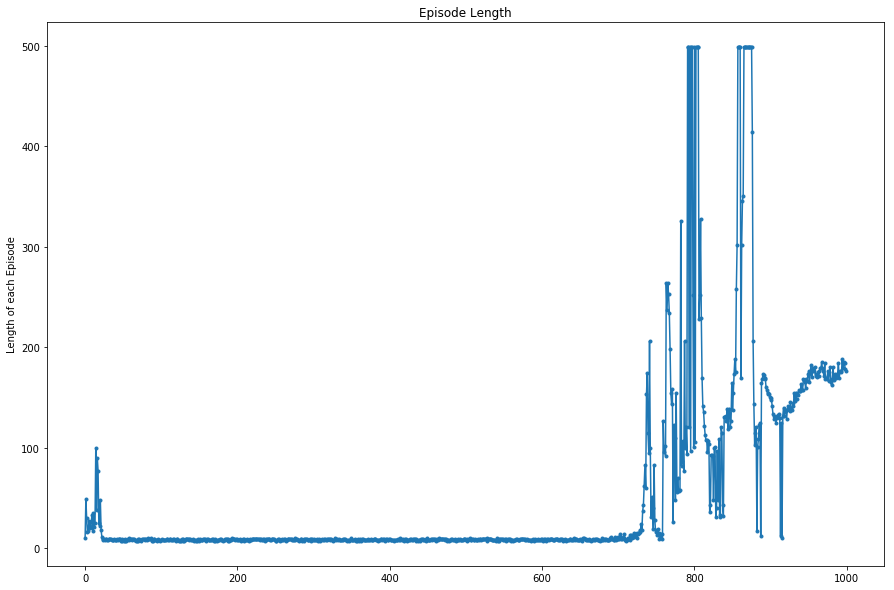

In [11]:
# Making plots larger!
matplotlib.rcParams['figure.figsize'] = [15, 10]

# X Axis of the plots
xx = range(episodes_to_train)

plt.plot(xx, ep_history, '.-')
plt.title('Episode Length')
plt.ylabel('Length of each Episode')

plt.show()

## Notes

1. It seems Vanilla Policy gradient is achieving better performance after 350 episode.

### Useful Tools

1. [Detexify](http://detexify.kirelabs.org/symbols.html) is an awesome tool that helps me to find $\LaTeX$ symbols
1. [Makrdown Table Generator](https://www.tablesgenerator.com/markdown_tables)